# Dictionary Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import sys

sys.path += ['..']
from modules.manifolds.spd import SPD
from modules.dictionary_learning.spd_dictionary_learning import ApproximatedACSPDDLSC as DL
from modules.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

## load images

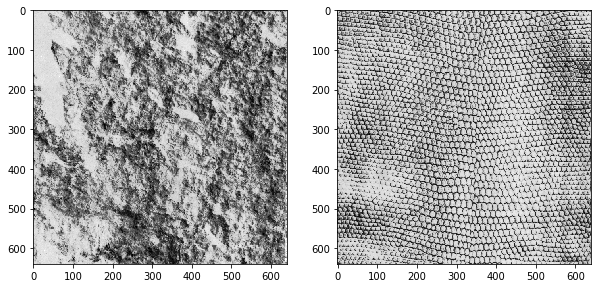

In [5]:
import os
import random

random.seed(0)

patch_size = (32, 32)
extraction_step = patch_size
n_components = 5
eps = 1e-16

path = '../data/brodatz'
imgs = [cv2.imread(os.path.join(path, f'D{i}.png'), False) for i in range(2, 7)]
# imgs = [cv2.imread(os.path.join(path, f'D{i}.png'), False) for i in range(2, 11)]

patches = [extract_patches_2d(img, patch_size, extraction_step).astype(np.float) for img in imgs]
length, half_length = len(patches[0]), len(patches[0]) // 20
shuffled_indices = list(range(length))
random.shuffle(shuffled_indices)

train_patches = np.vstack([patch[shuffled_indices[:half_length]] for patch in patches])
test_patches = np.vstack([patch[shuffled_indices[half_length:]] for patch in patches])

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(imgs[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgs[1], cmap='gray')

## Dictionary Learning

$$\mathop{\rm{minimize}}_{\mathcal{D}, W}\ \frac{1}{2}\sum_{i=1}^n\left\|\sum_{j=1}^mw_{ij}a_j - x_i\right\|_{x_i}^2 + \lambda\|W\|_1\quad
\text{subject to}\ a_j \in \mathcal{P}(r),\ \sum_{j=1}^m w_{ij} = 1$$

画像

In [6]:
# %%time
kernels = [
    np.array([[0,0,0],[-1,0,1],[0,0,0]]),
    np.array([[0,-1,0],[0,0,0],[0,1,0]]),
    np.array([[0,0,0],[-1,2,-1],[0,0,0]]),
    np.array([[0,-1,0],[0,2,0],[0,-1,0]])
]

def extract_feature(patches: np.ndarray, kernels: list, eps: float=1e-8):
    n_patches, p_h, p_w = patches.shape[:3]
    res = np.empty((n_patches, p_h * p_w, 1 + len(kernels)))

    res[:,:,0] = patches.reshape(-1, p_h * p_w)
    for i, kernel in enumerate(kernels):
        res[:,:,i+1] = np.vstack([np.abs(cv2.filter2D(p, cv2.CV_64F, kernel)) for p in patches]).reshape(-1, p_h * p_w)
    return np.array([np.cov(x, rowvar=False) + np.eye(1 + len(kernels)) * eps for x in res])

train_feature = extract_feature(train_patches, kernels)
test_feature = extract_feature(test_patches, kernels)

## Sparse Coding

### Symmetrix Positive Definite Matrix

In [7]:
%%prun
max_iter = 50
dl = DL(
    n_components = n_components ** 2,
    max_iter = max_iter,
    extended_output = True,
    initial_step = 1e-2,
    armijo_param = 1e-16,
    max_iter_dl = 50,
    rho = 1e-4,
    tau = len(train_feature),
    max_iter_sp = 100,
    n_job = 1
)

dl.fit(train_feature)

100%|██████████| 50/50 [02:39<00:00,  3.19s/it]

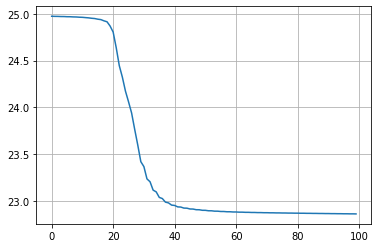

In [8]:
plt.plot(dl.f)
plt.grid(True)
plt.show()

In [9]:
train_transformed = dl.transform(train_feature)
%prun test_transformed = dl.transform(test_feature)

## SVM

### Symmetric Positive Definite Matrix

In [41]:
from sklearn.model_selection import train_test_split

label = np.hstack([[i]*half_length for i in range(len(imgs))]).astype(np.float)
X_train, X_test, y_train, y_test = train_test_split(train_transformed, label, train_size=0.8, random_state=0)

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from tqdm import tqdm

C = np.logspace(0, 5, 100)
acc = list()
for c in tqdm(C):
    clf = SVC(C=c, gamma='scale', random_state=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, pred))

100%|██████████| 100/100 [00:00<00:00, 611.37it/s]


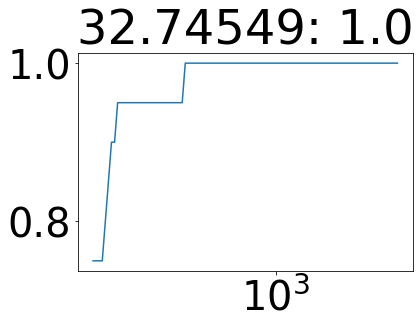

In [43]:
plt.plot(C, acc)
plt.xscale('log')
plt.title(f'{round(C[np.argmax(acc)], 5)}: {round(np.max(acc), 5)}')
plt.show()

In [44]:
import seaborn as sns
clf = SVC(C=C[np.argmax(acc)], gamma='scale', random_state=0)
clf.fit(train_transformed, label)
pred = clf.predict(test_transformed)
label = np.hstack([[i]*(len(pred) // 5) for i in range(len(imgs))]).astype(np.float)

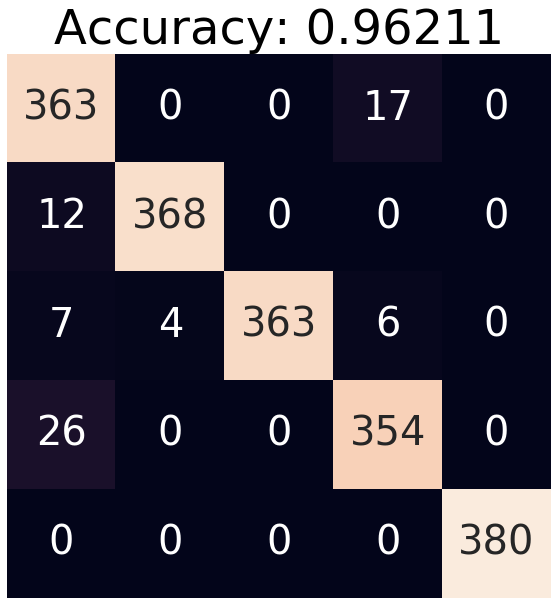

In [45]:
plt.rcParams["font.size"] = 40
plt.figure(figsize=(10, 10))
plt.title(f'Accuracy: {round(accuracy_score(label, pred), 5)}')
sns.heatmap(confusion_matrix(label, pred), square=True, annot=True, cbar=False, xticklabels=False, yticklabels=False, fmt='d')
plt.show()